# Sustainability Analysis of the Touring Industry

This notebook provides a sustainability analysis for the entertainment tour industry across the U.S. In particular, we will look at traveling patterns and decisions made by different performers and genres from an environmental impact standpoint. In hindsight, there are various reasons for tour routes: music release promotions, audience base, media attention, profit optimization, and many other objectives. 

From https://en.wikipedia.org/wiki/SeatGeek:
> SeatGeek is a mobile-focused ticket platform that enables users to buy and sell tickets for live sports, concerts and theater events. SeatGeek allows both mobile app and desktop users to browse events, view interactive color-coded seatmaps, complete purchases, and receive electronic or print tickets. The list of events on SeatGeek shows prices for ticket inventories aggregated from ticket exchanges such as TicketNetwork, TicketsNow, and Razorgator.
>
> Tickets are sorted using the company's DealScore algorithm which finds the combination of best available price and seat location for a particular event. Historically, SeatGeek provided price forecast information in a similar manner to Farecast, an airline ticket aggregation and forecasting site purchased by Microsoft in 2008. SeatGeek has seen success in the mobile space, adopting Apple Pay to provide seamless purchase and payment.



<a id="Table_of_Contents"> </a>
# Table of Contents 

1. [Initial Data Management](#data_management)<br>
2. [Venue Capacity Distribution](#venue_capacity)<br>
3. [Clustering Analysis](#cluster_analysis)<br>
4. [Distance Matrices](#distance_matrices)<br>
5. [Outlier Detection](#outlier_detection)<br>
6. [Graphical Displays for Results](#visualizations)<br>
7. [Alternative Considerations](#alternative_considerations)<br>
8. [Final Takeaways and Conclusions](#conclusions)<br>

The following code block imports libraries that we will use for the analysis.

In [1]:
import datetime
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
#from ipywidgets import interact

import statsmodels.formula.api as smf
import dist_matrix as dm
import distribution_fitting as dist_fit

<a id="data_management"> </a>
# Initial Data Management

The data that we will be utilizing includes a `Genres` column that includes a delimited list of genres associated with the various performers that are identified with each event. For various parts of the analysis, we categorize events by genre. Thus, we need a way to determine all unique genres that occur in the data. The following code block defines a helper function that we use for this purpose. The function takes in a pandas `DataFrame` and a column (string) that indicates the column in the DataFrame that contains the genre string. It returns a list of all unique genres in the column.

[Back to Table of Contents](#Table_of_Contents)<br>

In [2]:
def get_list_of_genres(df, genre_col):
    '''
    This function takes a pandas DataFrame and the name of a column including 
    a genre string. The genre string is delimited by pipes ('|'), commas, and
    semicolons. The function handles all of these delimeters and returns a list
    of the unique values in the column, i.e., values occuring between the various
    delimeters.
    
    '''
    
    genres_list = df[genre_col].dropna().unique()
    genres_list = list(genres_list)
    genres_list = '|'.join(genres_list)
    genres_list = genres_list.replace('|',',')
    genres_list = genres_list.replace(';',',')
    genres_list = genres_list.split(',')
    genres_list = set(genres_list)
    genres_list = list(genres_list)
    genres_list.remove('')
    
    return genres_list

The following code block creates or reads in a set of files that provide information for listings and performs some simple cleaning steps. This data was collected using the seatgeek API. Details on the API can be found at https://platform.seatgeek.com/. You can toggle the value of the `recreate_data` variable to `True` to recreate the data. If the value is False, the code checks to see if the file `clean_data.pkl.gz` exists. If so, it reads the file. Otherwise, it creates the file.

In [3]:
recreate_data = False

pickle_filename = 'clean_data.pkl.gz'

if recreate_data or not os.path.exists(pickle_filename):
    
    print('Creating data.')
    data_directory = 'seatgeek_data/'
    available_files = [file for file in os.listdir(data_directory) if '.gz' in file]
    all_data = pd.DataFrame()
    for file in available_files:
        print(f'Joining file {file}')
        file_path = os.path.join(data_directory, file)
        all_data = pd.concat([all_data, pd.read_csv(file_path, compression = 'gzip')])
        
    print(f'Converting date columns to datetimes')
    all_data = all_data.reset_index(drop = True)
    for col in all_data.columns:
        if ('Date' in col) or (col == 'Scrape_Time'):
            all_data[col] = pd.to_datetime(all_data[col],
                                           errors = 'coerce')            

    print(f'Creating genre boolean columns')
    genres_list = get_list_of_genres(all_data, 'Genres')

    for current_genre in genres_list:
        all_data[current_genre] = 0
        mask = all_data['Genres'].fillna('').str.contains(current_genre)
        all_data.loc[mask, current_genre] = 1
        
    print(f'Final steps')
    all_data.columns = [column.replace(' ','_') if column not in genres_list else column for column in all_data.columns]
    all_data.columns = [column.replace('-','_') if column not in genres_list else column for column in all_data.columns]
    all_data = all_data.dropna(subset = ['Visible_Listings'])
    all_data = all_data.reset_index(drop = True)
    all_data['Unique_Events'] = all_data.groupby('Event_Name')['Event_ID'].transform('nunique')
    all_data.to_pickle(pickle_filename, 
                       compression = 'gzip')
else:
    print('Reading data.')
    all_data = pd.read_pickle(pickle_filename, 
                              compression = 'gzip')
    
print(f"The data has {all_data.shape[0]} rows and {all_data.shape[1]} columns.")
print(f"The data considers {all_data['Event_ID'].nunique()} unique events.")
print(f"The median number of listing for an event is {all_data['Visible_Listings'].median()}.")

Reading data.
The data has 694178 rows and 64 columns.
The data considers 244343 unique events.
The median number of listing for an event is 12.0.


The following code block executes the `get_list_of_genres` function to generate the unique genres. Ideally, when performing the analysis we would like to be able to *turn on or off* any of these genres.

In [4]:
get_list_of_genres(all_data, 'Genres')

['Latin',
 'Folk',
 'Rap',
 'Jazz',
 'Techno',
 'Reggae',
 'Classic Rock',
 'Classical',
 'Hard Rock',
 'Rnb',
 'Indie',
 'Punk',
 'Alternative',
 'Electronic',
 'Country',
 'Rock',
 'Blues',
 'Pop',
 'Soul',
 'Hip-Hop']

The following code block shows how we can use a dictionary comprehension to generate a dictionary where the *keys* are the unique genres and the *values* are a `boolean` value.

In [5]:
{key: False for key in get_list_of_genres(all_data, 'Genres')}

{'Latin': False,
 'Folk': False,
 'Rap': False,
 'Jazz': False,
 'Techno': False,
 'Reggae': False,
 'Classic Rock': False,
 'Classical': False,
 'Hard Rock': False,
 'Rnb': False,
 'Indie': False,
 'Punk': False,
 'Alternative': False,
 'Electronic': False,
 'Country': False,
 'Rock': False,
 'Blues': False,
 'Pop': False,
 'Soul': False,
 'Hip-Hop': False}

The following code block shows how we can use a dictionary such as that shown to easily toggle the genres that we want to include.

In [6]:
genres_to_include_dict = {
    'Rock': True,
    'Blues': False,
    'Classical': False,
    'Hip-Hop': False, 
    'Indie': False,
    'Punk': False, 
    'Techno': False,
    'Electronic': False, 
    'Jazz': False,
    'Classic Rock': True,
    'Hard Rock': True,
    'Folk': False,
    'Latin': False,
    'Country': True, 
    'Pop': False,
    'Reggae': False,
    'Alternative': False,
    'Rnb': False, 
    'Rap': False,
    'Soul': False
}

genres_to_include = [key for key, val in genres_to_include_dict.items() if val == True]
print(f'Including {genres_to_include}')

Including ['Rock', 'Classic Rock', 'Hard Rock', 'Country']


The following code block uses this dictionary to create a subsetted DataFrame with events related to the chosen genres. Five randomly selected rows are printed so that the reader can verify correctness.

In [7]:
genres_to_include = [key for key, val in genres_to_include_dict.items() if val == True]

base_columns = ['Performers', 'Venue_ID', 'Event_ID', 'Venue_Capacity', 
                'Latitude', 'Longitude', 'UTC_Datetime', 'Venue_City', 'Venue_State']

mask = None
for current_genre in genres_to_include:
    if mask is None:
        mask = (all_data[current_genre] == 1)
    else:
        mask = mask | (all_data[current_genre] == 1)
        
temp_df = all_data.loc[mask, base_columns + genres_to_include]
temp_df.sample(5)

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country
580769,A Day To Remember; Beartooth; I Prevail,3706,4953825,5700,43.6277,-116.2076,2019-10-16 00:30:00,Boise,ID,1,0,1,0
407905,CAAMP,1899,4867914,550,33.7242,-117.9062,2019-10-19 03:00:00,Santa Ana,CA,0,0,0,1
417861,Jim Jefferies,689,4800481,1300,40.1035,-75.1683,2019-10-05 23:00:00,Glenside,PA,1,0,0,0
410172,Bon Iver; Yo La Tengo,7546,4884820,19000,40.6821,-73.9778,2019-10-11 23:30:00,Brooklyn,NY,1,0,0,0
490943,Melanie Martinez; Lauren Ruth Ward,717,4946161,1870,39.7516,-104.9970,2019-11-18 03:00:00,Denver,CO,1,0,0,0


<a id="venue_capacity"> </a>
# Venue Capacity Distribution

In this section, we will discuss the venue capacity distribution to prepare the data for the clustering analysis in the next section. The following code block removes replicated performers through use of the split, explode, and strip functions. First, the split function returns a list of all of the words in the string using a semicolon as the seperator. Next, the explode function transforms each element of a list-like to a row. Lastly, the strip function removes leading and trailing plus signs. Five randomly selected rows are printed so that the reader can verify correctness.

In [8]:
temp_df['Performers'] = temp_df['Performers'].str.split(';')
temp_df = temp_df.explode('Performers')
temp_df['Performers'] = temp_df['Performers'].str.strip(' +')
temp_df = temp_df.drop_duplicates()
temp_df.sample(5)

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country
102146,Wayne Newton,5586,5129033,0,36.1260,-115.1480,2020-06-04 03:00:00,Las Vegas,NV,1,0,0,0
508457,Jeff Bradshaw,7066,4898123,0,32.3347,-90.1693,2019-11-30 01:00:00,Jackson,MS,1,0,0,0
262036,Black Label Society,1249,5150722,6500,43.1676,-77.6012,2020-03-27 23:00:00,Rochester,NY,1,0,1,0
88821,B (Beatles Tribute),5511,4854720,420,36.1260,-115.1480,2020-02-25 01:30:00,Las Vegas,NV,1,0,0,0
66062,Tunnel Vision,3808,4843269,500,29.5528,-95.1026,2019-06-17 01:00:00,Houston,TX,1,0,0,0


The following code block is used to group the data by `Performers` and `Venue_Capacity` in order to objectively cluster in the next section. The summation of `Venue_Capacity` for each performer will allow comparisons of audience reach for the given data read in or created. We will only utilize data points that have a venue capacity greater than 0 to showcase differences. Furthermore, a `Cumulative_Capacity` column is created to represent successive additions. 

In [9]:
temp_df_grouped = temp_df.groupby(['Performers'])['Venue_Capacity'].sum()
temp_df_grouped = temp_df_grouped.reset_index()
temp_df_grouped = temp_df_grouped[temp_df_grouped['Venue_Capacity'] != 0]
temp_df_grouped = temp_df_grouped.sort_values('Venue_Capacity')
temp_df_grouped['Cumulative_Capacity'] = temp_df_grouped['Venue_Capacity'].cumsum()
temp_df_grouped['Cumulative_Capacity'] = temp_df_grouped['Cumulative_Capacity']/temp_df_grouped['Venue_Capacity'].sum()
temp_df_grouped.sample(5)

,Performers,Venue_Capacity,Cumulative_Capacity
3384,Of Mice & Men,10624,0.0406
2232,Jill Scott,30273,0.1103
688,Bruce In the USA,10100,0.0389
3405,On A Pale Horse,700,0.0010
1717,Gavin Harrison,1750,0.0043


The following code block creates a histogram of the data based on the `Venue_Capacity`. Given that the touring industry data is not normally distributed, this graph is displayed on a logarithmic scale to more easily visualize the distribution.  The x-axis represents the venue capacity values logarithmically; 2 corresponds with $10^{2}$, 3 corresponds with $10^{3}$, and so on. Therefore, the majority of performers have a total venue capacity of between 1,000 and 10,000. The solid black vertical lines represent the percentile breakdowns of $25^{th}$, $60^{th}$, and $95^{th}$. 

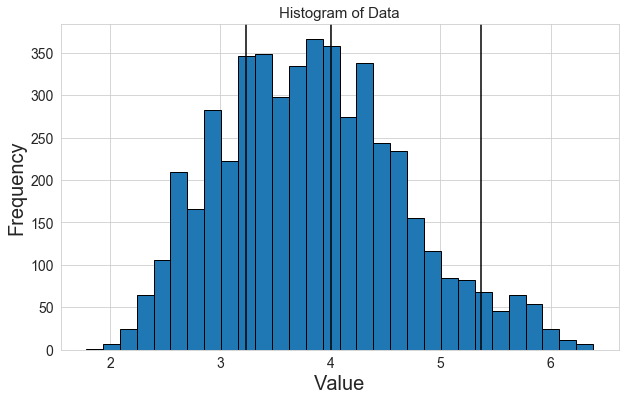

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

log10_values = np.log10(temp_df_grouped['Venue_Capacity'])

ax.hist(log10_values, edgecolor = 'k', bins = 30)
ax.axvline(x = np.percentile(log10_values, 25), color = 'k')
ax.axvline(x = np.percentile(log10_values, 60), color = 'k')
ax.axvline(x = np.percentile(log10_values, 95), color = 'k')
ax.set_ylabel('Frequency', fontsize = 20)
ax.set_xlabel('Value', fontsize = 20)
ax.set_title('Histogram of Data', fontsize = 15)
ax.tick_params(labelsize = 14)
plt.show()

<a id="cluster_analysis"> </a>
# Clustering Analysis

In this section, we will discuss the clustering analysis approach for the data utilized. Clustering is beneficial for grouping a set of objects in clusters that are similar to each other. For the touring industry, it is neccesary to group performers by both the number of performances as well as the audience base size; these data attributes being `Event_ID` and `Venue_Capacity`.

As previously completed, the genres we will include as a list are `Rock`, `Classic Rock`, `Hard Rock`, and `Country`. For clustering, we will only consider one genre at a time, indicated by the index; indexing always starts at 0. The following code block uses the enumerate function to print the index for all genres in the `genres_to_include` list.

In [11]:
print('The genres are:')
for index, genre in enumerate(genres_to_include):
    print(f'{index}: {genre}')

The genres are:
0: Rock
1: Classic Rock
2: Hard Rock
3: Country


The following code block refers to one specific genre in the list in order to cluster genres separately. 

In [12]:
current_genre_index = 0
current_genre = genres_to_include[current_genre_index]
print(f'The current genre is {current_genre}')

The current genre is Rock


The following code block filters out the data to only include the data points that have a genre of `Rock` in the `temp_df` `DataFrame`. The `mask` assignment outputs an array of boolean values for which the condition is met. Then another `DataFrame` is created as the subset of the original. To note, the `loc` function accesses the group of rows and columns by the boolean array. The first five rows are shown through use of the `head` function.

In [13]:
mask = temp_df[current_genre] == 1

temp_kmeans = temp_df.loc[mask, :].copy()
temp_kmeans.head()

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country
2067,B (Beatles Tribute),5511,4709218,420,36.1260,-115.1480,2019-06-12 00:30:00,Las Vegas,NV,1,0,0,0
2071,B (Beatles Tribute),5511,4709217,420,36.1260,-115.1480,2019-06-13 00:30:00,Las Vegas,NV,1,0,0,0
2114,B (Beatles Tribute),5511,4709216,420,36.1260,-115.1480,2019-06-27 00:30:00,Las Vegas,NV,1,0,0,0
2130,B (Beatles Tribute),5511,4709215,420,36.1260,-115.1480,2019-07-03 00:30:00,Las Vegas,NV,1,0,0,0
2134,B (Beatles Tribute),5511,4709213,420,36.1260,-115.1480,2019-07-04 00:30:00,Las Vegas,NV,1,0,0,0


The following code block creates another new subsetted `DataFrame` to be generated for clustering. Once again, the split and explode functions are used to return a list of all of the words in the string and transform each element of a list-like to a row. We also want to return the `DataFrame` with duplicated rows removed. In addition, only relevant columns are kept for the analysis, as well as excluding data points with a venue capacity of 0. The dimensions of the original and current dataframes are printed to verify subsetted completion.

In [14]:
temp_kmeans.loc[:, 'Performers'] = temp_kmeans.loc[:,'Performers'].str.split(';')
temp_kmeans = temp_kmeans.explode('Performers')
temp_kmeans = temp_kmeans.drop_duplicates()

columns_to_keep = ['Performers', 'Venue_ID', 'Event_ID', 'Venue_Capacity', 'Rock', 'Classic Rock', 
                   'Hard Rock', 'Country', 'Venue_City', 'Venue_State']

temp_kmeans = temp_kmeans[columns_to_keep]

temp_kmeans = temp_kmeans[temp_kmeans['Venue_Capacity'] > 0]
print(f"The original data has {all_data.shape[0]} rows and {all_data.shape[1]} columns.")
print('-'*50)
print(f"The current data has {temp_kmeans.shape[0]} rows and {temp_kmeans.shape[1]} columns.")

The original data has 694178 rows and 64 columns.
--------------------------------------------------
The current data has 41932 rows and 10 columns.


Once we have our newly formed `DataFrame`, we need to filter out duplicated Event IDs for clustering. Due to the explode function previously completed, we must eliminate replicated Event IDs. Also, many of the events in our dataset include performances that involve multiple performers (i.e. music festivals) which certainly reflect duplication. Therefore, the nunique function returns a series with the number of distinct observations. 

In [15]:
print(f"The number of Event IDs in this data is {temp_kmeans['Event_ID'].count()}")
print('-'*50)
print(f"The number of unique Event IDs in this data is {temp_kmeans['Event_ID'].nunique()}")

The number of Event IDs in this data is 41932
--------------------------------------------------
The number of unique Event IDs in this data is 28119


The following code block is used to overwrite the `DataFrame` by applying the group by function. The data must be grouped by the number of unique events and the summation of the venue capacity, for every single performer in `current_genre`. The `agg_dict` is a dictionary where the keys are expected to occur as columns in the `DataFrame`. For each of these keys, the value in the dictionary can be a string or a list of strings that correspond to pandas aggregations. Finally, normalization is necessary for the grouped by data in order to change the numeric values to a common scale for consistent comparison. 


In [16]:
agg_dict = {'Event_ID':'nunique',
            'Venue_Capacity': 'sum'}

temp_kmeans = temp_kmeans.groupby(['Performers']).agg(agg_dict)

temp_kmeans = temp_kmeans[['Event_ID', 'Venue_Capacity']]/temp_kmeans[['Event_ID', 'Venue_Capacity']].max()
temp_kmeans.sample(5)

,Event_ID,Venue_Capacity
Performers,,
David Lee Roth,0.3577,0.3497
Koffin Kats,0.0219,0.0007
Nation of Language,0.0219,0.0008
Paula Abdul,0.1752,0.0289
Lakeside,0.0073,0.0008


The following code block is used to produce a scatterplot of the dataset based upon the number of events and audience reach. Each datapoint in the scatterplot represents a performer for the current genre of `Rock`. As completed, the dataframe is normalized so the x-axis and y-axis range from 0 to 1. For interpretation purposes, the most popular performers are going to have both relatively high number of events and venue capacity, or just a high venue capacity.  

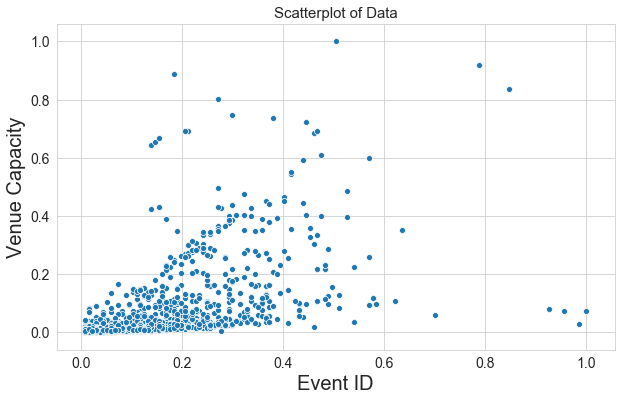

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.scatterplot(x = 'Event_ID', 
                y = 'Venue_Capacity', 
                data = temp_kmeans)

ax.set_ylabel('Venue Capacity', fontsize = 20)
ax.set_xlabel('Event ID', fontsize = 20)
ax.set_title('Scatterplot of Data', fontsize = 15)
ax.tick_params(labelsize = 14)
plt.show()

The following code block demonstrates the use of the elbow method in order to estimate the optimal number of clusters for the `KMeans` function. The one disadvantage to this clustering technique is that specification of the number of clusters is required, therefore the elbow method is useful. This method determines the number of clusters based on the sum of squared distance (SSE) between data points and their assigned clusters' centroids. We pick k where the SSE starts to flatten out and form an elbow, hence the method name. The ideal number of clusters can be seen as 3 or 4; but after further analysis, 3 clusters causes too much aggregation.

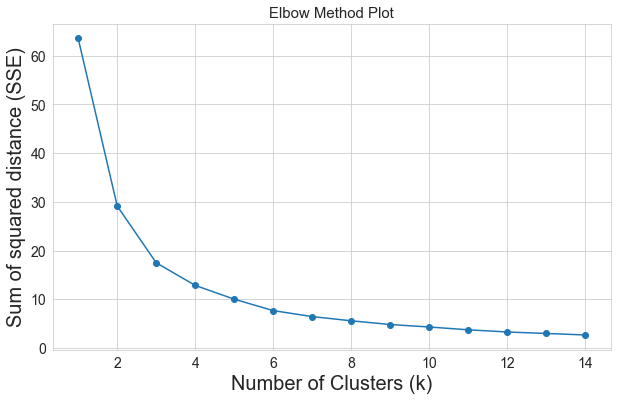

In [18]:
knn_array = temp_kmeans.values

sse = []
list_k = list(range(1, 15))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(knn_array)
    sse.append(km.inertia_)
    
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(list_k, sse, '-o')

ax.set_ylabel('Sum of squared distance (SSE)', fontsize = 20)
ax.set_xlabel('Number of Clusters (k)', fontsize = 20)
ax.set_title('Elbow Method Plot', fontsize = 15)
ax.tick_params(labelsize = 14)
plt.show()

Once the scatterplot is generated and the number of clusters is objectively determined, we can begin to cluster with the `KMeans` function. The number of clusters is set to 4, the maximum iterations is set to 1,000 for the k-means algorithm, and the random number generation for centroid initialization is turned off. The predict function then classifies the closest cluster each data point belongs to. As shown, there are 4 clusters broken out by Event ID and venue capacity.

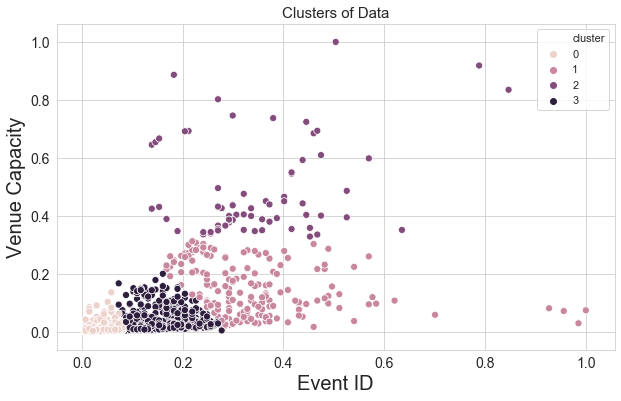

In [19]:
temp_knn_model = KMeans(n_clusters=4,
                        random_state = 0,
                        max_iter=1000,)

kmeans_fit = temp_knn_model.fit(knn_array)

temp_kmeans['cluster'] = kmeans_fit.predict(knn_array)


fig, ax = plt.subplots(1,1, figsize = (10, 6))

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

sns.scatterplot(x = 'Event_ID', 
                y = 'Venue_Capacity', 
                hue = 'cluster',
                s = 50,
                legend = 'full', 
                data = temp_kmeans)

ax.set_ylabel('Venue Capacity', fontsize = 20)
ax.set_xlabel('Event ID', fontsize = 20)
ax.set_title('Clusters of Data', fontsize = 15)
ax.tick_params(labelsize = 14)
ax.legend(fontsize = 11)
plt.show()

<a id="distance_matrices"> </a>
# Distance Matrices

In this section, we will determine the distance traveled for all performers in chronological order across all clusters. This will allow us to compare and contrast touring distances, as well as analyze the industry from a sustainability viewpoint. In order to execute correctly, we need to calculate distances by performer within each cluster. The following code block first only considers datapoints in cluster 0. A `DataFrame` is subsetted that only includes rows in cluster 0 and performers within the `current_cluster_performers` assignment. This subset is then sorted first by `Performers`, then by `UTC_Datetime` to prepare for the distance calculations in chronological order. 

In [20]:
current_cluster = 0

current_cluster_df = temp_kmeans[temp_kmeans['cluster'] == current_cluster]
current_cluster_performers = current_cluster_df.index.tolist()
current_cluster_df = temp_df[temp_df['Performers'].isin(current_cluster_performers)]
current_cluster_df = current_cluster_df.sort_values(['Performers', 'UTC_Datetime'])
current_cluster_df.head(10)

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country
81619,!!! (Chk Chk Chk),18020,4868221,0,40.2728,-76.8905,2019-08-11 00:00:00,Harrisburg,PA,1,0,0,0
345668,!!! (Chk Chk Chk),1751,4912634,300,38.5717,-121.4683,2019-09-28 04:00:00,Sacramento,CA,1,0,0,0
425122,!!! (Chk Chk Chk),47558,4923489,150,37.7487,-122.4155,2019-09-29 04:00:00,San Francisco,CA,1,0,0,0
410757,!!! (Chk Chk Chk),1666,4915867,1970,45.5438,-122.6750,2019-10-01 04:00:00,Portland,OR,1,0,0,0
421557,!!! (Chk Chk Chk),245249,4928634,0,42.3071,-83.1147,2019-10-07 23:00:00,Detroit,MI,1,0,0,0
413223,!!! (Chk Chk Chk),1446,4912656,476,42.3551,-71.1316,2019-10-11 00:00:00,Boston,MA,1,0,0,0
341817,!!! (Chk Chk Chk),399,4910046,550,40.7121,-73.9543,2019-10-13 01:00:00,Brooklyn,NY,1,0,0,0
350955,!!! (Chk Chk Chk),3114,4912620,0,40.2327,-74.0314,2019-10-13 23:00:00,Asbury Park,NJ,1,0,0,0
348481,!!! (Chk Chk Chk),8679,4898961,650,39.9597,-75.1605,2019-10-19 01:00:00,Philadelphia,PA,1,0,0,0
47550,...And You Will Know Us by the Trail of Dead,1063,4820538,350,34.0785,-118.2660,2019-06-22 03:30:00,Los Angeles,CA,1,0,0,0


The following code block creates four new columns for use in identifying the last performance for each performer. The group by and transform functions are used to self produce the value for these columns across all the performers. This will ensure correct distance calculations that don't carry over into different performers. The `DataFrame` index is finally reset. 

In [21]:
current_cluster_df['Last_Latitude'] = current_cluster_df.groupby('Performers')['Latitude'].transform('last')
current_cluster_df['Last_Longitude'] = current_cluster_df.groupby('Performers')['Longitude'].transform('last')
current_cluster_df['Last_Date'] = current_cluster_df.groupby('Performers')['UTC_Datetime'].transform('last')
current_cluster_df['Last_Event'] = current_cluster_df.groupby('Performers')['Event_ID'].transform('last')

current_cluster_df = current_cluster_df.reset_index(drop = True)
current_cluster_df.head(10)

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country,Last_Latitude,Last_Longitude,Last_Date,Last_Event
0,!!! (Chk Chk Chk),18020,4868221,0,40.2728,-76.8905,2019-08-11 00:00:00,Harrisburg,PA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961
1,!!! (Chk Chk Chk),1751,4912634,300,38.5717,-121.4683,2019-09-28 04:00:00,Sacramento,CA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961
2,!!! (Chk Chk Chk),47558,4923489,150,37.7487,-122.4155,2019-09-29 04:00:00,San Francisco,CA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961
3,!!! (Chk Chk Chk),1666,4915867,1970,45.5438,-122.6750,2019-10-01 04:00:00,Portland,OR,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961
4,!!! (Chk Chk Chk),245249,4928634,0,42.3071,-83.1147,2019-10-07 23:00:00,Detroit,MI,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961
5,!!! (Chk Chk Chk),1446,4912656,476,42.3551,-71.1316,2019-10-11 00:00:00,Boston,MA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961
6,!!! (Chk Chk Chk),399,4910046,550,40.7121,-73.9543,2019-10-13 01:00:00,Brooklyn,NY,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961
7,!!! (Chk Chk Chk),3114,4912620,0,40.2327,-74.0314,2019-10-13 23:00:00,Asbury Park,NJ,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961
8,!!! (Chk Chk Chk),8679,4898961,650,39.9597,-75.1605,2019-10-19 01:00:00,Philadelphia,PA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961
9,...And You Will Know Us by the Trail of Dead,1063,4820538,350,34.0785,-118.2660,2019-06-22 03:30:00,Los Angeles,CA,1,0,0,0,36.7586,-119.8102,2020-01-25 04:00:00,5133171


The following code block is used to determine successive destinations and identify the last performances. The next event locations and dates are established by the NumPy roll function. The NumPy roll function allows us to shift the values by a specific amount; in this case the shift is -1 to shift one position earlier. Therefore, the first performance `Next_Latitude`, `Next_Longitude`, and `Next_Date` correspond to the next performance `Latitude`, `Longitude`, and `UTC_Datetime`. The last performance for each performer is then distinguished by when the `UTC_Datetime` and `Last_Date` correspond, as well as the `Event_ID` and `Last_Event`.

In [22]:
current_cluster_df['Next_Latitude'] = np.roll(current_cluster_df['Latitude'], shift = -1)
current_cluster_df['Next_Longitude'] = np.roll(current_cluster_df['Longitude'], shift = -1)
current_cluster_df['Next_Date'] = np.roll(current_cluster_df['UTC_Datetime'], shift = -1)

last_date_mask = current_cluster_df['Last_Date'] == current_cluster_df['UTC_Datetime']
last_event_mask = current_cluster_df['Last_Event'] == current_cluster_df['Event_ID']
mask = last_date_mask & last_event_mask

The following code block creates the three new columns that equate to the final destination and performance date for each performer's performance. This ensures that the last performance distance for each performer is 0, as we can't confirm mileage after all performances in the dataset. The first ten rows of the `DataFrame` are printed to verify correctness and visually demonstrate the process. 

In [23]:
current_cluster_df.loc[mask, 'Next_Latitude'] = current_cluster_df.loc[mask, 'Last_Latitude'] 
current_cluster_df.loc[mask, 'Next_Longitude'] = current_cluster_df.loc[mask, 'Last_Longitude'] 
current_cluster_df.loc[mask, 'Next_Date'] = current_cluster_df.loc[mask, 'Last_Date'] 

current_cluster_df.head(10)

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country,Last_Latitude,Last_Longitude,Last_Date,Last_Event,Next_Latitude,Next_Longitude,Next_Date
0,!!! (Chk Chk Chk),18020,4868221,0,40.2728,-76.8905,2019-08-11 00:00:00,Harrisburg,PA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,38.5717,-121.4683,2019-09-28 04:00:00
1,!!! (Chk Chk Chk),1751,4912634,300,38.5717,-121.4683,2019-09-28 04:00:00,Sacramento,CA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,37.7487,-122.4155,2019-09-29 04:00:00
2,!!! (Chk Chk Chk),47558,4923489,150,37.7487,-122.4155,2019-09-29 04:00:00,San Francisco,CA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,45.5438,-122.6750,2019-10-01 04:00:00
3,!!! (Chk Chk Chk),1666,4915867,1970,45.5438,-122.6750,2019-10-01 04:00:00,Portland,OR,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,42.3071,-83.1147,2019-10-07 23:00:00
4,!!! (Chk Chk Chk),245249,4928634,0,42.3071,-83.1147,2019-10-07 23:00:00,Detroit,MI,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,42.3551,-71.1316,2019-10-11 00:00:00
5,!!! (Chk Chk Chk),1446,4912656,476,42.3551,-71.1316,2019-10-11 00:00:00,Boston,MA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,40.7121,-73.9543,2019-10-13 01:00:00
6,!!! (Chk Chk Chk),399,4910046,550,40.7121,-73.9543,2019-10-13 01:00:00,Brooklyn,NY,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,40.2327,-74.0314,2019-10-13 23:00:00
7,!!! (Chk Chk Chk),3114,4912620,0,40.2327,-74.0314,2019-10-13 23:00:00,Asbury Park,NJ,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,39.9597,-75.1605,2019-10-19 01:00:00
8,!!! (Chk Chk Chk),8679,4898961,650,39.9597,-75.1605,2019-10-19 01:00:00,Philadelphia,PA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,39.9597,-75.1605,2019-10-19 01:00:00
9,...And You Will Know Us by the Trail of Dead,1063,4820538,350,34.0785,-118.2660,2019-06-22 03:30:00,Los Angeles,CA,1,0,0,0,36.7586,-119.8102,2020-01-25 04:00:00,5133171,37.8686,-122.2585,2019-06-23 03:30:00


The following code block is used to calculate daily distance in the next steps. The `Days_Since_Last_Event` column is created, which takes the difference in the `Next_Date` from the `UTC_Datetime`. This is then converted to seconds and finally into days to allow for consistency without rounding issues. The first 10 rows are printed to display the newly formed column.  

In [24]:
current_cluster_df['Days_Since_Last_Event'] = current_cluster_df['Next_Date'] - current_cluster_df['UTC_Datetime']
current_cluster_df['Days_Since_Last_Event'] = current_cluster_df['Days_Since_Last_Event'].dt.total_seconds()
seconds_in_day = 60*60*24
current_cluster_df['Days_Since_Last_Event'] = current_cluster_df['Days_Since_Last_Event']/seconds_in_day
current_cluster_df.head(10)

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country,Last_Latitude,Last_Longitude,Last_Date,Last_Event,Next_Latitude,Next_Longitude,Next_Date,Days_Since_Last_Event
0,!!! (Chk Chk Chk),18020,4868221,0,40.2728,-76.8905,2019-08-11 00:00:00,Harrisburg,PA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,38.5717,-121.4683,2019-09-28 04:00:00,48.1667
1,!!! (Chk Chk Chk),1751,4912634,300,38.5717,-121.4683,2019-09-28 04:00:00,Sacramento,CA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,37.7487,-122.4155,2019-09-29 04:00:00,1.0000
2,!!! (Chk Chk Chk),47558,4923489,150,37.7487,-122.4155,2019-09-29 04:00:00,San Francisco,CA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,45.5438,-122.6750,2019-10-01 04:00:00,2.0000
3,!!! (Chk Chk Chk),1666,4915867,1970,45.5438,-122.6750,2019-10-01 04:00:00,Portland,OR,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,42.3071,-83.1147,2019-10-07 23:00:00,6.7917
4,!!! (Chk Chk Chk),245249,4928634,0,42.3071,-83.1147,2019-10-07 23:00:00,Detroit,MI,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,42.3551,-71.1316,2019-10-11 00:00:00,3.0417
5,!!! (Chk Chk Chk),1446,4912656,476,42.3551,-71.1316,2019-10-11 00:00:00,Boston,MA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,40.7121,-73.9543,2019-10-13 01:00:00,2.0417
6,!!! (Chk Chk Chk),399,4910046,550,40.7121,-73.9543,2019-10-13 01:00:00,Brooklyn,NY,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,40.2327,-74.0314,2019-10-13 23:00:00,0.9167
7,!!! (Chk Chk Chk),3114,4912620,0,40.2327,-74.0314,2019-10-13 23:00:00,Asbury Park,NJ,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,39.9597,-75.1605,2019-10-19 01:00:00,5.0833
8,!!! (Chk Chk Chk),8679,4898961,650,39.9597,-75.1605,2019-10-19 01:00:00,Philadelphia,PA,1,0,0,0,39.9597,-75.1605,2019-10-19 01:00:00,4898961,39.9597,-75.1605,2019-10-19 01:00:00,0.0000
9,...And You Will Know Us by the Trail of Dead,1063,4820538,350,34.0785,-118.2660,2019-06-22 03:30:00,Los Angeles,CA,1,0,0,0,36.7586,-119.8102,2020-01-25 04:00:00,5133171,37.8686,-122.2585,2019-06-23 03:30:00,1.0000


The following code block calculates the distance and daily distance for each event in the dataset. The distance is calculated by using the `dist_matrix` function. The inputs are the dataframe, starting latitude and longitude, and ending latitude and longitude. The daily distance is calculated by taking the distance divided by the `Days_Since_Last_Event` column. Lastly, the columns initially created to identify the last performances are dropped. The first ten rows of the `DataFrame` are printed to verify correctness. 

In [25]:
current_cluster_df['Distance'] = dm.distance_start_finish(current_cluster_df, 
                                                            'Latitude', 
                                                            'Longitude', 
                                                            'Next_Latitude', 
                                                            'Next_Longitude')  

current_cluster_df['Daily_Distance'] = current_cluster_df['Distance']/current_cluster_df['Days_Since_Last_Event']

current_cluster_df = current_cluster_df.drop(columns = ['Last_Latitude', 
                                                        'Last_Longitude', 
                                                        'Last_Date', 
                                                        'Last_Event', 
                                                        'Next_Latitude', 
                                                        'Next_Longitude',
                                                        'Next_Date',
                                                        'Days_Since_Last_Event'])
current_cluster_df.head(10)

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country,Distance,Daily_Distance
0,!!! (Chk Chk Chk),18020,4868221,0,40.2728,-76.8905,2019-08-11 00:00:00,Harrisburg,PA,1,0,0,0,2355.4449,48.9020
1,!!! (Chk Chk Chk),1751,4912634,300,38.5717,-121.4683,2019-09-28 04:00:00,Sacramento,CA,1,0,0,0,76.6374,76.6374
2,!!! (Chk Chk Chk),47558,4923489,150,37.7487,-122.4155,2019-09-29 04:00:00,San Francisco,CA,1,0,0,0,538.4168,269.2084
3,!!! (Chk Chk Chk),1666,4915867,1970,45.5438,-122.6750,2019-10-01 04:00:00,Portland,OR,1,0,0,0,1960.0055,288.5898
4,!!! (Chk Chk Chk),245249,4928634,0,42.3071,-83.1147,2019-10-07 23:00:00,Detroit,MI,1,0,0,0,611.1907,200.9394
5,!!! (Chk Chk Chk),1446,4912656,476,42.3551,-71.1316,2019-10-11 00:00:00,Boston,MA,1,0,0,0,184.7995,90.5140
6,!!! (Chk Chk Chk),399,4910046,550,40.7121,-73.9543,2019-10-13 01:00:00,Brooklyn,NY,1,0,0,0,33.3482,36.3798
7,!!! (Chk Chk Chk),3114,4912620,0,40.2327,-74.0314,2019-10-13 23:00:00,Asbury Park,NJ,1,0,0,0,62.5471,12.3043
8,!!! (Chk Chk Chk),8679,4898961,650,39.9597,-75.1605,2019-10-19 01:00:00,Philadelphia,PA,1,0,0,0,0.0000,nan
9,...And You Will Know Us by the Trail of Dead,1063,4820538,350,34.0785,-118.2660,2019-06-22 03:30:00,Los Angeles,CA,1,0,0,0,343.8220,343.8220


Since the last performance for every performer will have a distance of 0, these daily distances will be represented as nan; not a number because of 0 in the numerator for the daily distance calculations. These observations will be filtered out in the Alternative Considerations section to allow for an accurate analysis. 

The code demonstrated above was completed only for the first cluster. The following code block calculates the distance and daily distance for every performer in all four clusters. A for loop is used to iterate over all the performers in every cluster. Once again, the columns initially created to identify the last performances are dropped. The empty `DataFrame` is concatenated with `data_with_dist` and `current_cluster_df` to include the entire dataset. The `DataFrame` index is finally reset. 

In [26]:
data_with_dist = pd.DataFrame()

for current_cluster in temp_kmeans['cluster'].unique():
    print(f'Starting cluster {current_cluster}')
    current_cluster_df = temp_kmeans[temp_kmeans['cluster'] == current_cluster]
    current_cluster_performers = current_cluster_df.index.tolist()
    current_cluster_df = temp_df[temp_df['Performers'].isin(current_cluster_performers)]
    current_cluster_df = current_cluster_df.sort_values(['Performers', 'UTC_Datetime'])
    current_cluster_df['Last_Latitude'] = current_cluster_df.groupby('Performers')['Latitude'].transform('last')
    current_cluster_df['Last_Longitude'] = current_cluster_df.groupby('Performers')['Longitude'].transform('last')
    current_cluster_df['Last_Date'] = current_cluster_df.groupby('Performers')['UTC_Datetime'].transform('last')
    current_cluster_df['Last_Event'] = current_cluster_df.groupby('Performers')['Event_ID'].transform('last')
    current_cluster_df = current_cluster_df.reset_index(drop = True)
    current_cluster_df['Next_Latitude'] = np.roll(current_cluster_df['Latitude'], shift = -1)
    current_cluster_df['Next_Longitude'] = np.roll(current_cluster_df['Longitude'], shift = -1)
    current_cluster_df['Next_Date'] = np.roll(current_cluster_df['UTC_Datetime'], shift = -1)
    current_cluster_df['Days_Since_Last_Event'] = current_cluster_df['Next_Date'] - current_cluster_df['UTC_Datetime']
    current_cluster_df['Days_Since_Last_Event'] = current_cluster_df['Days_Since_Last_Event'].dt.total_seconds()
    seconds_in_day = 60*60*24
    current_cluster_df['Days_Since_Last_Event'] = current_cluster_df['Days_Since_Last_Event']/seconds_in_day
    last_date_mask = current_cluster_df['Last_Date'] == current_cluster_df['UTC_Datetime']
    last_event_mask = current_cluster_df['Last_Event'] == current_cluster_df['Event_ID']
    mask = last_date_mask & last_event_mask
    current_cluster_df.loc[mask, 'Next_Latitude'] = current_cluster_df.loc[mask, 'Last_Latitude'] 
    current_cluster_df.loc[mask, 'Next_Longitude'] = current_cluster_df.loc[mask, 'Last_Longitude'] 

    current_cluster_df['Distance'] = dm.distance_start_finish(current_cluster_df, 
                                                                'Latitude', 
                                                                'Longitude', 
                                                                'Next_Latitude', 
                                                                'Next_Longitude')  

    current_cluster_df['Daily_Distance'] = current_cluster_df['Distance']/current_cluster_df['Days_Since_Last_Event']

    current_cluster_df = current_cluster_df.drop(columns = ['Last_Latitude', 
                                                            'Last_Longitude', 
                                                            'Last_Date', 
                                                            'Last_Event', 
                                                            'Next_Latitude', 
                                                            'Next_Longitude',
                                                            'Next_Date',
                                                            'Days_Since_Last_Event'])

    data_with_dist = pd.concat([data_with_dist, current_cluster_df], sort = False)
data_with_dist = data_with_dist.reset_index(drop = True)

Starting cluster 0
Starting cluster 3
Starting cluster 1
Starting cluster 2


The folllowing code block aggregates the normalized data by each cluster. The mean values are displayed for the number of unique events and audience base size to compare across all four clusters. The clusters are sorted in descending order by `Venue_Capacity` followed by `Event_ID`. This was decided upon due to the belief that the most popular performers' significance relies more heavily on their audience reach rather than the number of events; top musicians might have fewer events scheduled because they are reaching a vast amount of people. 

In [27]:
cluster_groupby_data = temp_kmeans.groupby('cluster')[['Event_ID', 'Venue_Capacity']].mean()
cluster_groupby_data = cluster_groupby_data.sort_values(by = ['Venue_Capacity', 'Event_ID'], ascending = False)
cluster_groupby_data

,Event_ID,Venue_Capacity
cluster,,
2,0.3487,0.4919
1,0.3344,0.1473
3,0.1439,0.0284
0,0.0246,0.0039


Once we have the grouped cluster data as a `DataFrame`, we need to convert this to a list in order to pass it in the next function. The converted list is shown below in the order consistent with the previous code block.

In [28]:
sorted_cluster_list = cluster_groupby_data.index.tolist()
sorted_cluster_list

[2, 1, 3, 0]

The following code block creates a dictionary that will correctly map the current clusters to easily understood sequential sorted clusters. The enumerate method adds a counter to an iterable and returns it in the form of an enumerate object. Therefore, the cluster list is converted to a logical sequence that starts with 1 and ends with 4. 

In [29]:
cluster_mapper = {}
for index, cluster_number in enumerate(sorted_cluster_list, 1):
    cluster_mapper[cluster_number] = index
cluster_mapper

{2: 1, 1: 2, 3: 3, 0: 4}

The following code block correctly maps the corresponding clusters from the `temp_kmeans` assignment to the new `data_with_dist` dataframe. The first five rows are printed to represent the cluster column.

In [30]:
cluster_to_performer_map = temp_kmeans['cluster'].to_dict()
data_with_dist['Cluster'] = data_with_dist['Performers'].map(cluster_to_performer_map)
data_with_dist.head()

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country,Distance,Daily_Distance,Cluster
0,!!! (Chk Chk Chk),18020,4868221,0,40.2728,-76.8905,2019-08-11 00:00:00,Harrisburg,PA,1,0,0,0,2355.4449,48.9020,0
1,!!! (Chk Chk Chk),1751,4912634,300,38.5717,-121.4683,2019-09-28 04:00:00,Sacramento,CA,1,0,0,0,76.6374,76.6374,0
2,!!! (Chk Chk Chk),47558,4923489,150,37.7487,-122.4155,2019-09-29 04:00:00,San Francisco,CA,1,0,0,0,538.4168,269.2084,0
3,!!! (Chk Chk Chk),1666,4915867,1970,45.5438,-122.6750,2019-10-01 04:00:00,Portland,OR,1,0,0,0,1960.0055,288.5898,0
4,!!! (Chk Chk Chk),245249,4928634,0,42.3071,-83.1147,2019-10-07 23:00:00,Detroit,MI,1,0,0,0,611.1907,200.9394,0


The following code block represents the addition of a new column that includes the correct, sequential clusters. This is completed by the map function, which returns a map object of the results to each item of the given iterable. Ten randomly selected rows are printed to demonstrate mapped cluster correctness. 

In [31]:
data_with_dist['Sorted Cluster'] = data_with_dist['Cluster'].map(cluster_mapper)
data_with_dist.sample(10)

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country,Distance,Daily_Distance,Cluster,Sorted Cluster
8486,Kasim Sulton,5603,4914676,0,40.7761,-73.9828,2019-09-13 00:00:00,New York,NY,1,0,0,0,75.3244,0.4430,0,4
54659,Alabama,119,5038136,13184,42.9642,-85.6589,2020-10-24 23:00:00,Grand Rapids,MI,1,0,0,1,0.0000,-0.0000,2,1
34450,Paul Anka,3356,5157720,2870,40.7563,-73.5754,2020-05-16 00:00:00,Westbury,NY,1,0,0,0,0.0000,-0.0000,3,3
2417,Broncho,849,4764058,750,39.7312,-104.9713,2019-07-21 02:00:00,Denver,CO,1,0,0,0,982.1594,8.3160,0,4
47279,Gary Puckett,303,4646253,8500,33.6772,-117.9086,2019-07-22 03:00:00,Costa Mesa,CA,1,0,0,0,1763.1089,178.1668,1,2
19348,YG,7836,4941881,9200,29.4054,-98.6383,2019-10-26 08:30:00,San Antonio,TX,1,0,0,0,0.0000,0.0000,0,4
47068,Fitz and the Tantrums,455,4753690,4600,32.7751,-117.0762,2019-08-10 03:00:00,San Diego,CA,1,0,0,0,109.0172,109.0172,1,2
20294,Allen Stone,3703,4628606,18000,39.6104,-104.8814,2019-06-21 00:45:00,Englewood,CO,1,0,0,0,651.3468,4.4904,3,3
58146,Trans-Siberian Orchestra,112,4972141,18504,35.2272,-80.8442,2019-12-08 01:00:00,Charlotte,NC,1,0,0,0,800.4664,19211.1925,2,1
17795,Tonic,426080,4842830,8000,32.8765,-96.9413,2019-09-02 00:00:00,Irving,TX,1,0,1,0,403.9590,5.9333,0,4


The following code block groups the data by each cluster and represents descriptive statistics for comparison. As shown, the number of performers increases significantly as the cluster number descends. The first cluster has the highest median distance while the third cluster has the highest maximum distance. Further analysis needs to be completed; outlier considerations and other summary statistics. 

In [32]:
agg_dict = {'Distance':['median', 'max', 'mean'],
            'Performers': ['nunique']}

data_with_dist.groupby('Sorted Cluster').agg(agg_dict)

Distance                    Performers
                 median       max     mean    nunique
Sorted Cluster                                       
1              270.4890 4947.3960 394.9517         71
2              225.0119 5042.8457 349.5382        195
3              262.9994 5083.7090 415.6883        886
4              247.1261 5069.4317 481.1105       3335

<a id="outlier_detection"> </a>
# Outlier Detection

In this section, we will showcase why removing outliers leads to an accurate analysis. The following code block is used to create a boxplot to display contrasts among the clusters. A boxplot is a standardized way of displaying the distribution of data based on the minimum, first quartile, median, third quartile, and maximum values. 

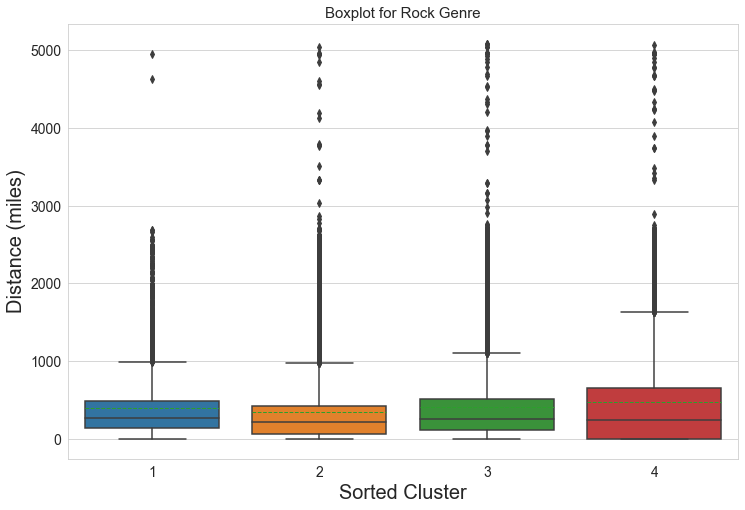

In [33]:
fig, ax = plt.subplots(1,1, figsize = (12, 8))

sns.boxplot(x = 'Sorted Cluster',
            y = 'Distance',
            data = data_with_dist,
            showmeans=True, meanline=True)

ax.set_ylabel('Distance (miles)', fontsize = 20)
ax.set_xlabel('Sorted Cluster', fontsize = 20)
ax.set_title('Boxplot for Rock Genre', fontsize = 15)
ax.tick_params(labelsize = 14)
plt.show()

Boxplots are useful in displaying the distribution of data, symmetrical vs. asymmetrical, grouping of data, and skewness. The minimum and maximum values are the black horizontal lines stemming off the whiskers of the graph. The interquartile range (IQR) represents the $25^{th}$ to the $75^{th}$ percentile; the colored rectangles of the graph. The median is the black horizontal line within the colored rectangles and the mean is the dashed green line. There are a tremendous amount of outliers, as represented by all the datapoints that fall outside of these attributes. Therefore, we must remove these datapoints to increase analysis accuracy. 

The following code block is used for outlier removal. The outlier detection is computed by cluster in order to take datapoint removal separately. The `dist_fit.handle_outliers` function inputs include the data, outlier threshold, and output to return as a boolean array. One key concept to note is that this function, as opposed to traditional methods, does not assume that the data is symmetric. This is relevant for our analysis as the touring industry data is certainly not symmetric. The `data_with_dist_outliers_removed` dataframe is then created that only includes datapoints equal to true. True indicates that a point is not an outlier.  

In [34]:
for current_cluster in data_with_dist['Sorted Cluster'].unique():
    print(f'Starting {current_cluster}')

    mask = data_with_dist['Sorted Cluster'] == current_cluster

    valid_values_list = dist_fit.handle_outliers(data_with_dist.loc[mask, 'Distance'], 
                                                 outlier_threshold = 1.0,
                                                 return_bool_array = True)

    data_with_dist.loc[mask, 'Valid'] = valid_values_list
    
data_with_dist_outliers_removed = data_with_dist[data_with_dist['Valid'] == True]

Starting 4
Starting 3
Starting 2
Starting 1


The following code block represents the updated boxplot with outlier removal. It can be seen that the outliers considerably far away from the maximum (past the outlier threshold of 1.0) are detected and removed. 

<a id="example_1"> </a>
Example 1

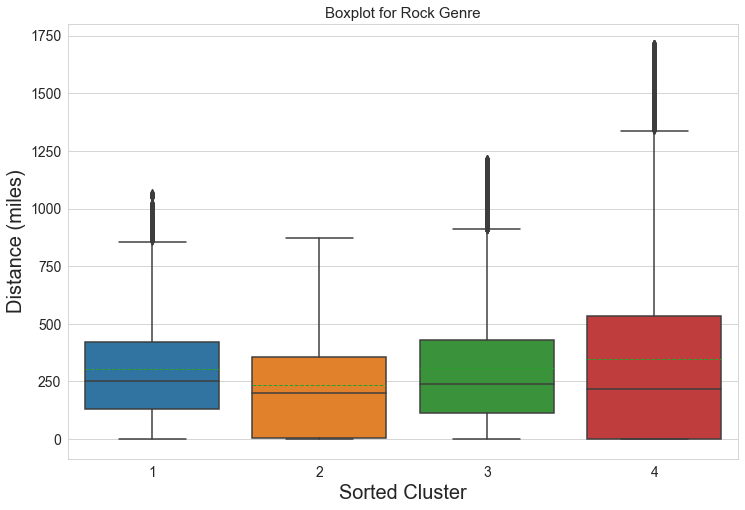

In [35]:
fig, ax = plt.subplots(1,1, figsize = (12, 8))
sns.boxplot(x = 'Sorted Cluster',
            y = 'Distance',
            data = data_with_dist_outliers_removed,
            showmeans=True, meanline=True)

ax.set_ylabel('Distance (miles)', fontsize = 20)
ax.set_xlabel('Sorted Cluster', fontsize = 20)
ax.set_title('Boxplot for Rock Genre', fontsize = 15)
ax.tick_params(labelsize = 14)
plt.show()

<a id="visualizations"> </a>
# Graphical Displays for Results

The following code block outputs additional summary statistics for analysis. The three user-defined functions represent the $10^{th}$, $90^{th}$, and $99^{th}$ quantiles of the distance values. The `agg_dict` method aggregates the parameters for analysis in order to group by in the final step. In addition, we filter out the datapoints that don't have a distance greater than 0 and include the `Venue_State` as Hawaii due to incorrect distance calculations.

In [36]:
def q10(x):
    return x.quantile(0.1)

def q90(x):
    return x.quantile(0.9)

def q99(x):
    return x.quantile(0.99)

agg_dict = {'Distance':['median', 'min', 'max', 'mean', 'std', 'count', q10, q90, q99],
            'Performers': ['nunique']}
data_with_dist_outliers_removed = data_with_dist_outliers_removed[data_with_dist_outliers_removed['Distance'] > 0]
data_with_dist_outliers_removed = data_with_dist_outliers_removed[data_with_dist_outliers_removed['Venue_State'] != 'HI']

desc_stats_rock = data_with_dist_outliers_removed.groupby('Sorted Cluster').agg(agg_dict)
desc_stats_rock

Distance                                                     \
                 median    min       max     mean      std  count      q10   
Sorted Cluster                                                               
1              288.6680 1.7922 1068.7132 350.3619 227.1128   3024 117.3773   
2              259.9850 1.7468  872.8144 309.2144 194.2437   7361  97.9956   
3              287.9844 0.2965 1215.4515 359.0393 257.8871  19414  96.7815   
4              352.8993 0.0533 1715.0394 478.6412 390.2923  13264  89.5054   

                                   Performers  
                     q90       q99    nunique  
Sorted Cluster                                 
1               693.6061 1000.8305         71  
2               618.0915  834.6945        185  
3               744.7043 1134.5623        876  
4              1053.1590 1625.9239       2328

The output above shows that the descriptive statistics have changed after outlier removal. As expected, the median values increased while the mean values decreased due to the elimination of higher distance datapoints. Due to this, cluster 4 now has the highest median, max, mean, and standard deviation. 

The following code block is used to display a pointplot for the distance as a function of cluster. A pointplot represents an estimate of central tendency for a numeric variable by the position of scatter plot points and provides some indication of the uncertainty around that estimate using error bars. Any overlap between points and error bars for multiple clusters indicates insignificance in mean distance differences. 

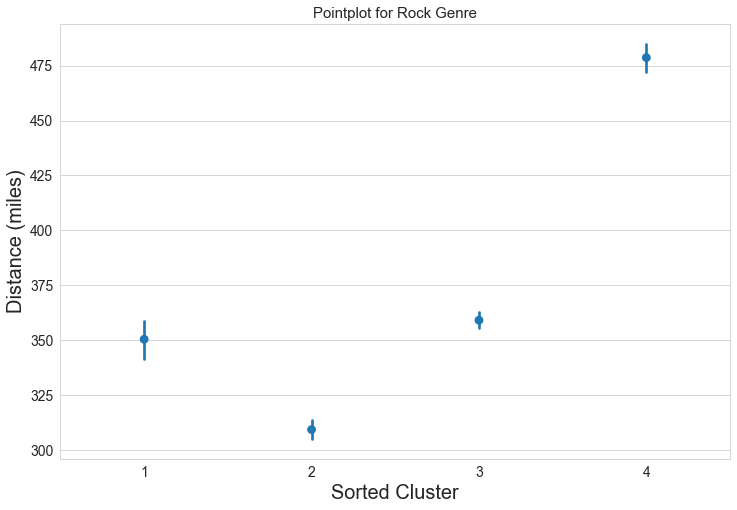

In [37]:
fig, ax = plt.subplots(1,1, figsize = (12, 8))
sns.pointplot(x = 'Sorted Cluster',
              y = 'Distance',
              join = False,
              data = data_with_dist_outliers_removed)
ax.set_ylabel('Distance (miles)', fontsize = 20)
ax.set_xlabel('Sorted Cluster', fontsize = 20)
ax.set_title('Pointplot for Rock Genre', fontsize = 15)
ax.tick_params(labelsize = 14)
plt.show()

The above pointplot demonstrates that the mean distance differences between cluster 1 and 3 are insignificant, while cluster 2 is significantly lower and cluster 4 is significantly higher than the rest of the clusters. This exemplifies that the least popular performers in the Rock genre are having the greatest impact from an environmental standpoint. 

The following code block is used to display histograms for each cluster separately. Histograms are useful in demonstrating the distribution of the respective data. The number of histograms to create is specified by the length of `unique_clusters`, which is 4. The for loop will then display the histogram for the current cluster iterated based on the distance values. The median distance value for each cluster is also represented on the graph as the black vertical line. 

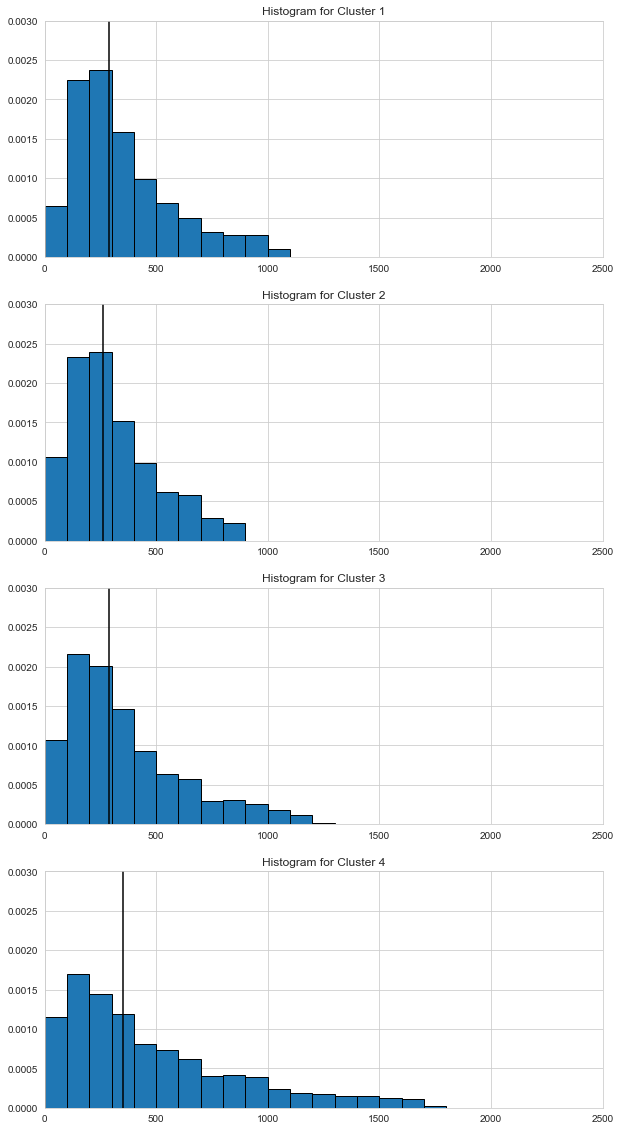

In [38]:
unique_clusters = data_with_dist_outliers_removed['Sorted Cluster'].unique()
unique_clusters = sorted(unique_clusters)
num_rows = len(unique_clusters)

fig, ax = plt.subplots(num_rows, 1, figsize = (10, 5*num_rows))

for current_ax, current_cluster in zip(ax, unique_clusters):

    hist_data = data_with_dist_outliers_removed.loc[data_with_dist_outliers_removed['Sorted Cluster'] == current_cluster,
                                                    'Distance'].values 
    current_ax.hist(hist_data,
                    bins = [i*100 for i in range(22)],
                    density = True,
                    edgecolor = 'k')
    
    current_ax.axvline(np.median(hist_data), color = 'k')
    current_ax.set_title(f'Histogram for Cluster {current_cluster}')
    
    current_ax.set_xlim(0, 2500)
    current_ax.set_ylim(0, 0.003)

plt.show()

Once again, it can be interpreted from the histogram above that cluster 4 has the highest median and more performances with greater distances. However, the majority of the performance distances are between 100 and 400 miles. This also verifies that the least popular performers, cluster 4, are having the greatest impact from an environmental standpoint. 

<a id="alternative_considerations"> </a>
# Alternative Considerations

In this section, we will consider additional alternatives in order to accurately analyze the touring industry. Three other analyses to be completed are daily distance, distance by audience reach, and relative ratios by cluster. Daily distance is useful to acknowledge as a significant amount of consecutive performances cover multiple days or even weeks. Distance by audience reach is also beneficial because long touring routes that reach a tremendous amount of people are less impactful than touring routes that reach a minimal amount of people. Relative ratios by cluster is important to highlight differences in efficiency of travel and reach. All three alternatives will be demonstrated in this section. 

The following code block creates a new `DataFrame` that represents why daily distance is useful. Some consecutive performances are the next day, while others are weeks or even months away. 

In [39]:
data_with_dist_differences = data_with_dist[['Performers', 'UTC_Datetime', 'Distance', 'Daily_Distance']]
data_with_dist_differences.head(15)

,Performers,UTC_Datetime,Distance,Daily_Distance
0,!!! (Chk Chk Chk),2019-08-11 00:00:00,2355.4449,48.9020
1,!!! (Chk Chk Chk),2019-09-28 04:00:00,76.6374,76.6374
2,!!! (Chk Chk Chk),2019-09-29 04:00:00,538.4168,269.2084
3,!!! (Chk Chk Chk),2019-10-01 04:00:00,1960.0055,288.5898
4,!!! (Chk Chk Chk),2019-10-07 23:00:00,611.1907,200.9394
5,!!! (Chk Chk Chk),2019-10-11 00:00:00,184.7995,90.5140
6,!!! (Chk Chk Chk),2019-10-13 01:00:00,33.3482,36.3798
7,!!! (Chk Chk Chk),2019-10-13 23:00:00,62.5471,12.3043
8,!!! (Chk Chk Chk),2019-10-19 01:00:00,0.0000,-0.0000
9,...And You Will Know Us by the Trail of Dead,2019-06-22 03:30:00,343.8220,343.8220


The following code block is used for outlier removal for the `Daily_Distance` column. The outlier detection is computed by cluster in order to take datapoint removal separately. The `data_with_dist_daily_outliers_removed` dataframe is then created that only includes datapoints equal to true, indicating rows that aren't outliers. 

In [40]:
data_with_dist_daily = data_with_dist[data_with_dist['Distance'] > 0.0].copy()

data_with_dist_daily['Cluster'] = data_with_dist_daily['Performers'].map(cluster_to_performer_map)
data_with_dist_daily['Sorted Cluster'] = data_with_dist_daily['Cluster'].map(cluster_mapper)

for current_cluster in data_with_dist_daily['Sorted Cluster'].unique():
    print(f'Starting {current_cluster}')

    mask = data_with_dist_daily['Sorted Cluster'] == current_cluster

    valid_values_list = dist_fit.handle_outliers(data_with_dist_daily.loc[mask, 'Daily_Distance'],                                             
                                                 outlier_threshold = 1.0,
                                                 return_bool_array = True)

    data_with_dist_daily.loc[mask, 'Valid'] = valid_values_list
    
data_with_dist_daily_outliers_removed = data_with_dist_daily[data_with_dist_daily['Valid'] == True]

Starting 4
Starting 3
Starting 2
Starting 1


The following code block outputs additional summary statistics for analysis. The three user-defined functions represent the $10^{th}$, $90^{th}$, and $99^{th}$ quantiles of the distance values. The `agg_dict` method aggregates the parameters for analysis in order to group by in the final step.

In [41]:
def q10(x):
    return x.quantile(0.1)

def q90(x):
    return x.quantile(0.9)

def q99(x):
    return x.quantile(0.99)

agg_dict = {'Daily_Distance':['median', 'min', 'max', 'mean', 'std', 'count', q10, q90, q99],
            'Performers': ['nunique']}

desc_stats_rock_daily = data_with_dist_daily_outliers_removed.groupby('Sorted Cluster').agg(agg_dict)
desc_stats_rock_daily

Daily_Distance                                           \
                       median    min      max     mean      std  count   
Sorted Cluster                                                           
1                    169.4739 0.9980 465.4347 179.3902 102.8546   3128   
2                    167.1054 0.0541 477.0499 180.4938 113.0846   8032   
3                    160.0969 0.0065 491.9307 176.1326 116.8844  20506   
4                    103.7730 0.0043 449.6662 129.1668 109.3130  14151   

                                         Performers  
                   q10      q90      q99    nunique  
Sorted Cluster                                       
1              49.4777 323.5848 427.0340         71  
2              41.7908 344.6670 455.7709        185  
3              31.1713 348.7683 458.1662        877  
4               9.2129 297.8162 418.2602       2432

The above table shows that all of the clusters have very similar results besides cluster 4; cluster 4 median and mean are significantly lower than the other clusters.

The following code block represents the updated boxplot with outlier removal for daily distance. 

<a id="example_2"> </a>
Example 2

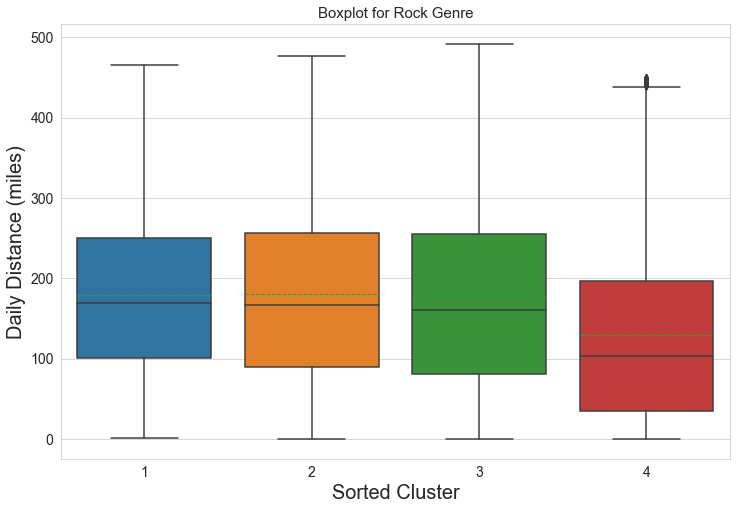

In [42]:
fig, ax = plt.subplots(1,1, figsize = (12, 8))

sns.boxplot(x = 'Sorted Cluster',
            y = 'Daily_Distance',
            data = data_with_dist_daily_outliers_removed,
            showmeans=True, meanline=True)

ax.set_ylabel('Daily Distance (miles)', fontsize = 20)
ax.set_xlabel('Sorted Cluster', fontsize = 20)
ax.set_title('Boxplot for Rock Genre', fontsize = 15)
ax.tick_params(labelsize = 14)
plt.show()

As compared to the boxplot originally constructed for distance, this daily distance boxplot shows some stark differences for cluster 4. The cluster 4 variability has diminished, and the median and mean values have decreased below all the other clusters. This is quite interesting to notice, which demonstrates why daily calculations are important. Since cluster 4 is represented as the least popular or even up-and-coming performers, there are a few possible explanations. These performers are willing to travel longer distances, as they will accept any and all events. However, these successive events might be played over weeks and months as opposed to days. Additionally, these performers don't have consistently busy schedules as compared to the more popular performers. Therefore, their net environmental effect isn't as high as the other cluster performers. 

The following code block represents a pointplot for the daily distance. 

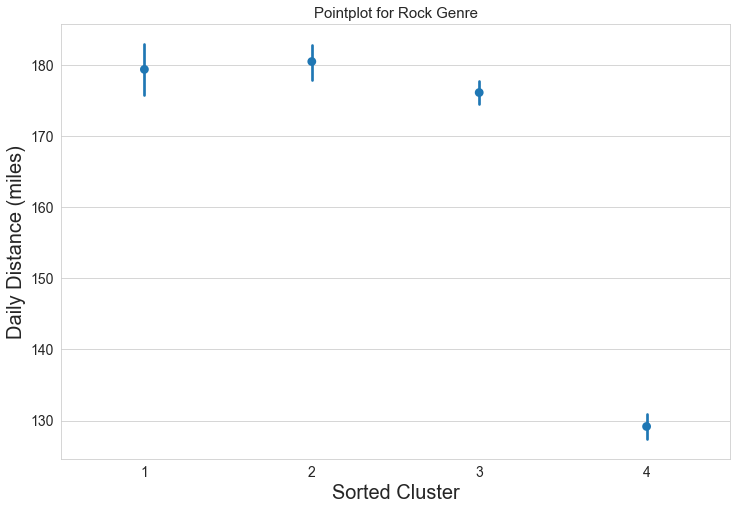

In [43]:
fig, ax = plt.subplots(1,1, figsize = (12, 8))
sns.pointplot(x = 'Sorted Cluster',
              y = 'Daily_Distance',
              join = False,
              data = data_with_dist_daily_outliers_removed)

ax.set_ylabel('Daily Distance (miles)', fontsize = 20)
ax.set_xlabel('Sorted Cluster', fontsize = 20)
ax.set_title('Pointplot for Rock Genre', fontsize = 15)
ax.tick_params(labelsize = 14)
plt.show()

The pointplot above verifies that the cluster 4 mean daily distance is significantly lower than the other clusters, while the first three clusters have a very similar mean daily distance. 

The following code block is used to display histograms of daily distance for each cluster separately.

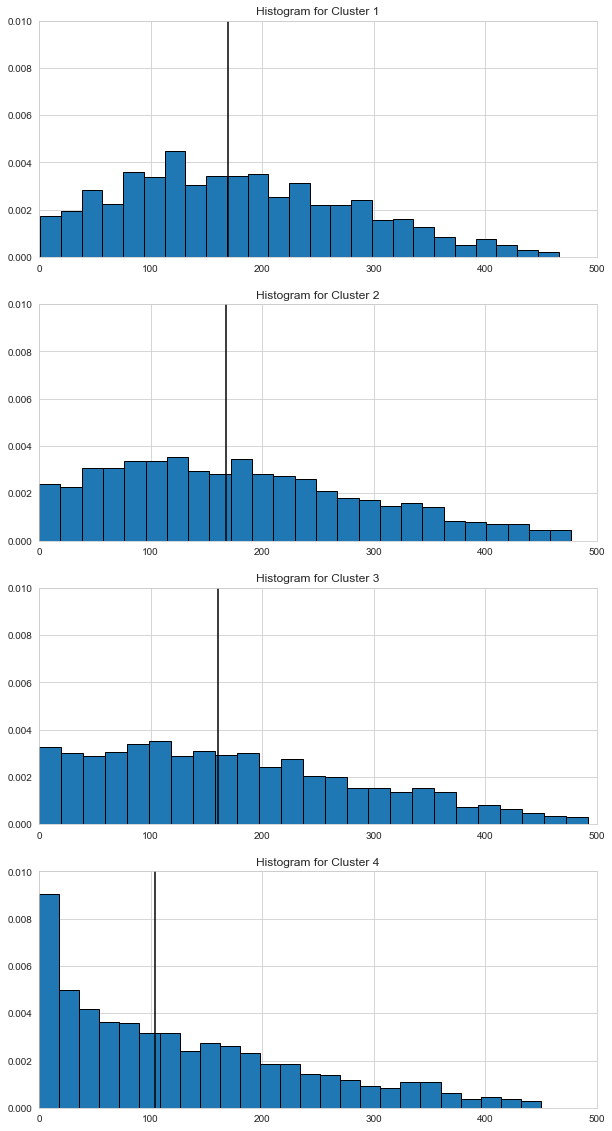

In [44]:
unique_clusters = data_with_dist_daily_outliers_removed['Sorted Cluster'].unique()
unique_clusters = sorted(unique_clusters)
num_rows = len(unique_clusters)

fig, ax = plt.subplots(num_rows, 1, figsize = (10, 5*num_rows))

for current_ax, current_cluster in zip(ax, unique_clusters):

    hist_data = data_with_dist_daily_outliers_removed.loc[data_with_dist_daily_outliers_removed['Sorted Cluster'] == current_cluster, 
                'Daily_Distance'].values 
    current_ax.hist(hist_data,
                    bins = 25,
                    density = True,
                    edgecolor = 'k')
    
    current_ax.axvline(np.median(hist_data), color = 'k')
    current_ax.set_title(f'Histogram for Cluster {current_cluster}')
    
    current_ax.set_xlim(0, 500)
    current_ax.set_ylim(0, .01)

plt.show()

The second alternative consideration is distance by audience reach. The following code block creates a new `DataFrame` that represents why distance by audience reach is useful. Some performers will travel upwards of 900 miles to reach about 500 people, while other performers travel less than 200 miles to reach around the same audience size. 

In [45]:
data_with_dist_reach = data_with_dist[['Performers', 'Venue_Capacity', 'UTC_Datetime', 'Distance']]
data_with_dist_reach = data_with_dist_reach[data_with_dist_reach['Venue_Capacity'] != 0]
data_with_dist_reach.head(15)

,Performers,Venue_Capacity,UTC_Datetime,Distance
1,!!! (Chk Chk Chk),300,2019-09-28 04:00:00,76.6374
2,!!! (Chk Chk Chk),150,2019-09-29 04:00:00,538.4168
3,!!! (Chk Chk Chk),1970,2019-10-01 04:00:00,1960.0055
5,!!! (Chk Chk Chk),476,2019-10-11 00:00:00,184.7995
6,!!! (Chk Chk Chk),550,2019-10-13 01:00:00,33.3482
8,!!! (Chk Chk Chk),650,2019-10-19 01:00:00,0.0000
9,...And You Will Know Us by the Trail of Dead,350,2019-06-22 03:30:00,343.8220
10,...And You Will Know Us by the Trail of Dead,1200,2019-06-23 03:30:00,340.9789
11,...And You Will Know Us by the Trail of Dead,18118,2020-01-18 04:00:00,956.8562
12,...And You Will Know Us by the Trail of Dead,525,2020-01-22 03:00:00,143.8556


The following code block is used to create a new column in the `DataFrame` that takes into account the distance traveled by audience reach. We first eliminate performances that didn't travel and performances that have a venue capacity of 0. A new column is then created, `Distance_by_Reach`, that is equal to the distance over the venue capacity. Lastly, this new column is normalized to a common scale for consistent comparison. The first five rows are printed to verify completion. 

In [46]:
data_with_dist_reach = data_with_dist.copy()
data_with_dist_reach = data_with_dist_reach[data_with_dist_reach['Distance'] > 0]
data_with_dist_reach = data_with_dist_reach[data_with_dist_reach['Venue_Capacity'] > 0]


data_with_dist_reach['Distance_by_Reach'] = (data_with_dist_reach['Distance'])\
                                            /(data_with_dist_reach['Venue_Capacity'])

data_with_dist_reach['Distance_by_Reach'] = (data_with_dist_reach['Distance_by_Reach'])\
                                            /(data_with_dist_reach['Distance_by_Reach']).max()
data_with_dist_reach.head()

,Performers,Venue_ID,Event_ID,Venue_Capacity,Latitude,Longitude,UTC_Datetime,Venue_City,Venue_State,Rock,Classic Rock,Hard Rock,Country,Distance,Daily_Distance,Cluster,Sorted Cluster,Valid,Distance_by_Reach
1,!!! (Chk Chk Chk),1751,4912634,300,38.5717,-121.4683,2019-09-28 04:00:00,Sacramento,CA,1,0,0,0,76.6374,76.6374,0,4,True,0.0099
2,!!! (Chk Chk Chk),47558,4923489,150,37.7487,-122.4155,2019-09-29 04:00:00,San Francisco,CA,1,0,0,0,538.4168,269.2084,0,4,True,0.1389
3,!!! (Chk Chk Chk),1666,4915867,1970,45.5438,-122.6750,2019-10-01 04:00:00,Portland,OR,1,0,0,0,1960.0055,288.5898,0,4,False,0.0385
5,!!! (Chk Chk Chk),1446,4912656,476,42.3551,-71.1316,2019-10-11 00:00:00,Boston,MA,1,0,0,0,184.7995,90.5140,0,4,True,0.0150
6,!!! (Chk Chk Chk),399,4910046,550,40.7121,-73.9543,2019-10-13 01:00:00,Brooklyn,NY,1,0,0,0,33.3482,36.3798,0,4,True,0.0023


The following code block is used for outlier removal for the `Distance_by_Reach` column. The outlier detection is computed by cluster in order to take datapoint removal separately.

In [47]:
for current_cluster in data_with_dist_reach['Sorted Cluster'].unique():
    print(f'Starting {current_cluster}')

    mask = data_with_dist_reach['Sorted Cluster'] == current_cluster

    valid_values_list = dist_fit.handle_outliers(data_with_dist_reach.loc[mask, 'Distance_by_Reach'], 
                                                 outlier_threshold = 1.0,
                                                 return_bool_array = True)

    data_with_dist_reach.loc[mask, 'Valid'] = valid_values_list
    
data_with_dist_reach_outliers_removed = data_with_dist_reach[data_with_dist_reach['Valid'] == True]

Starting 4
Starting 3
Starting 2
Starting 1


As completed previously, the following code block outputs additional summary statistics for analysis. The three user-defined functions represent the $10^{th}$, $90^{th}$, and $99^{th}$ quantiles of the distance values. The `agg_dict` method aggregates the parameters for analysis in order to group by in the final step.

In [48]:
def q10(x):
    return x.quantile(0.1)

def q90(x):
    return x.quantile(0.9)

def q99(x):
    return x.quantile(0.99)

agg_dict = {'Distance_by_Reach':['median', 'min', 'max', 'mean', 'std', 'count', q10, q90, q99],
            'Performers': ['nunique']}

desc_stats_rock_reach = data_with_dist_reach_outliers_removed.groupby('Sorted Cluster').agg(agg_dict)
desc_stats_rock_reach

Distance_by_Reach                                            \
                          median    min    max   mean    std  count    q10   
Sorted Cluster                                                               
1                         0.0007 0.0000 0.0034 0.0009 0.0007   2867 0.0002   
2                         0.0026 0.0000 0.0300 0.0052 0.0061   6666 0.0004   
3                         0.0077 0.0000 0.0593 0.0122 0.0125  15003 0.0013   
4                         0.0129 0.0000 0.1204 0.0224 0.0249   8974 0.0018   

                             Performers  
                  q90    q99    nunique  
Sorted Cluster                           
1              0.0019 0.0032         71  
2              0.0138 0.0268        186  
3              0.0306 0.0548        876  
4              0.0586 0.1086       2188

Since the newly created column is distance over audience reach, the higher output values represent more significant environmental impacts. Cluster 4 has the highest descriptive statistics overall, indicating that the least popular performers are traveling further distances to reach a smaller audience size. This group of performers has the greatest negative impact from a distance by audience reach standpoint. 

The following code block represents the updated boxplot with outlier removal. It can be determined from the graph that the variability and the distribution of the data increases as the cluster number ascends. 

<a id="example_3"> </a>
Example 3

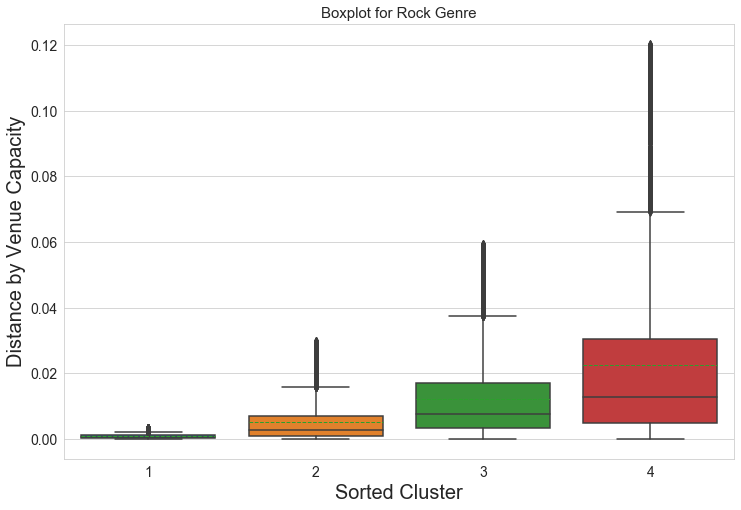

In [49]:
fig, ax = plt.subplots(1,1, figsize = (12, 8))
sns.boxplot(x = 'Sorted Cluster',
            y = 'Distance_by_Reach',
            data = data_with_dist_reach_outliers_removed,
            showmeans=True, meanline=True)

ax.set_ylabel('Distance by Venue Capacity', fontsize = 20)
ax.set_xlabel('Sorted Cluster', fontsize = 20)
ax.set_title('Boxplot for Rock Genre', fontsize = 15)
ax.tick_params(labelsize = 14)
plt.show()

The following code block represents a pointplot for the distance by audience reach.

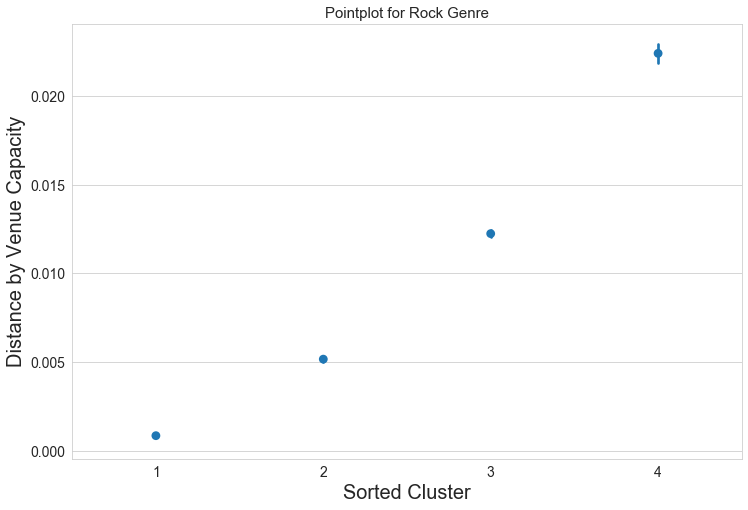

In [50]:
fig, ax = plt.subplots(1,1, figsize = (12, 8))
sns.pointplot(x = 'Sorted Cluster',
              y = 'Distance_by_Reach',
              join = False,
              data = data_with_dist_reach_outliers_removed)

ax.set_ylabel('Distance by Venue Capacity', fontsize = 20)
ax.set_xlabel('Sorted Cluster', fontsize = 20)
ax.set_title('Pointplot for Rock Genre', fontsize = 15)
ax.tick_params(labelsize = 14)
plt.show()

The above pointplot shows that each cluster's mean distance by venue capacity is significantly different than the others, with cluster 4 having the highest mean overall. 

The following code block is used to display histograms for each cluster separately. As noted, histograms are useful in demonstrating the distribution of the respective data.

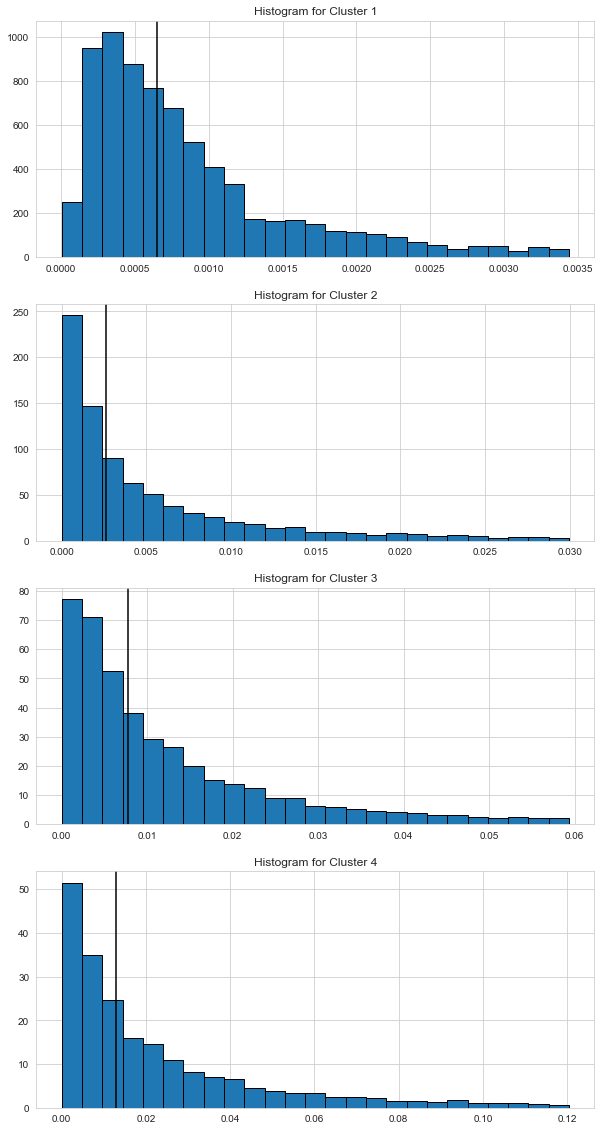

In [51]:
unique_clusters = data_with_dist_reach_outliers_removed['Sorted Cluster'].unique()
unique_clusters = sorted(unique_clusters)
num_rows = len(unique_clusters)

fig, ax = plt.subplots(num_rows, 1, figsize = (10, 5*num_rows))

for current_ax, current_cluster in zip(ax, unique_clusters):

    hist_data = data_with_dist_reach_outliers_removed.loc[data_with_dist_reach_outliers_removed['Sorted Cluster'] == current_cluster, 
                'Distance_by_Reach'].values 
    current_ax.hist(hist_data,
                    bins = 25,
                    density = True,
                    edgecolor = 'k')
    
    current_ax.axvline(np.median(hist_data), color = 'k')
    current_ax.set_title(f'Histogram for Cluster {current_cluster}')

plt.show()

It can be justified that the least popular performers are having the greatest impact as they travel longer distances to reach smaller audience sizes. 

The third alternative consideration is relative ratios by cluster. It's important to highlight differences in efficiency of travel and reach. The following code block creates a grouped table to represent clusters' distance, venue capacity, ratio, and relative ratio. The `DataFrame` is first grouped by sorted cluster with the total distance and venue capacity. A new column is then created that takes the `Venue_Capacity` divided by the `Distance`. An additional column is created that normalizes the ratio to allow for consistent comparison. This table is finally printed out to verify completion.  

<a id="example_4"> </a>
Example 4

In [52]:
relative_ratios = data_with_dist_outliers_removed.copy()

relative_ratios = relative_ratios.groupby('Sorted Cluster')[['Distance', 'Venue_Capacity']].sum()
relative_ratios['Ratio'] = relative_ratios['Venue_Capacity']/ relative_ratios['Distance']
relative_ratios['Relative_Ratio'] = relative_ratios['Ratio']/relative_ratios['Ratio'].max()
relative_ratios

,Distance,Venue_Capacity,Ratio,Relative_Ratio
Sorted Cluster,,,,
1,1059494.3154,57615667,54.3803,1.0000
2,2276127.0033,45065213,19.7991,0.3641
3,6970388.4205,42239462,6.0598,0.1114
4,6348696.9396,21136612,3.3293,0.0612


A few conclusions can be drawn from the table above. Cluster 1 has the lowest total distance while cluster 4 has the second highest total distance. As mentioned before, this can be explained by the fact that the least popular performers will travel as far as possible to play for any interested event. In addition, the number of performers increases as the sorted cluster number increases. Therefore, cluster 4 has thousands of performers to ultimately increase the overall distance traveled. Furthermore, due to the cluster analysis, as the sorted cluster number increases the overall venue capacity decreases. In light of this, there is a negative correlation between sorted cluster and ratio. Cluster 1 is reaching 54 people for every mile traveled, while cluster 4 is reaching 3 people for every mile traveled. The `Relative_Ratio` column further justifies this. In comparison to the efficiency of travel represented by cluster 1, the other clusters have a reduction in efficiency of 64%, 89%, and 94%. 

<a id="conclusions"> </a>
# Final Takeaways and Conclusions

This section will serve as consolidation for the final takeaways and conclusions from the analysis. The first major result is in regards to comparison of distance by each cluster. Cluster 4 is the least popular group of performers, determined from the initial clustering analysis by `Event_ID` and `Venue_Capacity`. The boxplot represents that this cluster has the highest median, mean, and variability of the distance distribution after outlier removal. Therefore, the least popular performers have the greatest negative impact from a sustainability standpoint when just considering distance. The graphical display in reference is example 1. 

[Example 1](#example_1)<br>

The second major conclusion stems from the daily distance analysis. This contradicts the previous conclusion as the cluster 4 median and mean daily distances are significantly lower than all the other clusters. In addition, the variability of the data distribution has decreased. As mentioned before, this can be explained by the fact that cluster 4 successive performances are more spread out than the other clusters. These performers will travel far distances in acceptance of events, but they are over the course of weeks or months. Additionally, these performers don't have consistently busy schedules as compared to the more popular performers. Therefore, their net environmental effect isn't as high as the other cluster performers on a per day basis. 

[Example 2](#example_2)<br>

The third major takeaway comes from the distance by audience reach analysis. Cluster 4 has the highest descriptive statistics overall, indicating that the least popular performers are traveling further distances to reach a smaller audience size. In addition, the variability and the distribution of the data increases as the cluster number ascends. Therefore, the performers in cluster 4 have the greatest negative impact from a distance by audience reach standpoint.


[Example 3](#example_3)<br>

The fourth major conclusion is the relative ratios table constructed in the alternative considerations section. Cluster 4 is reaching the least amount of people on a mileage basis for performances. This cluster is also 94% less efficient than cluster 1 from an audience and traveling perspective. This goes to show that the least popular performers are having the greatest negative effect environmentally. 

[Example 4](#example_4)<br>

Lastly, we must associate this sustainability analysis back to our original hypothesis. Initially we believed that the most popular performers, cluster 1, are most likely having the greatest envinronmental impact due to the contract terms. Concert promoters, also referred to as concert buyers, frequently insist on contract "riders" when partnering with the boooking agents, artists, and managers. These "riders" prohibit performers from scheduling other concerts within a certain radius and time period. For instance, the 2018 Coachella radius clauses stated that artists were restricted from performing in California, Arizona, Washington, and Oregon. Although this is preventing market area competition and protecting investments, a distance of over 1,200 miles is unreasonable. As a whole, our hypothesis was disproven because of the conclusions regarding the least popular performers. 

Our analysis only focused on distances traveled by the performers themselves. Moving forward, there are three overarching elements to be considered for sustainability of the touring industry; electricity and gas, goods and services, and transport. Within these sectors include rehearsals, venues, power demand, production equipment, stage set materials, audience, merchandise, concessions, etc.  

Even though the combination of sustainability and the performing arts traditionally isn't the most lucrative, the importance of the former integrated in with the latter is becoming more prevalent. Majort artists such as Billie Eilish, The 1975, and Coldplay are putting the importance of sustainable touring at the forefront. A London based company called Julie's Bicycle is shedding light on the environmental impact of the industry, and offering guidance on emissions abatement and improvement. This focus is significantly shifting the industry; it'll be extremely interesting to see how the industry landscape changes over the next 5-10 years. 